In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [45]:
df_train = pd.read_csv("../input/hrtech-hack-2022/train_dataset_train.csv")
df_test = pd.read_csv("../input/hrtech-hack-2022/test_dataset_test.csv")
df_calls = pd.read_csv("../input/hrtech-hack-2022/Calls.csv")
df_connection_time = pd.read_csv("../input/hrtech-hack-2022/ConnectionTime.csv")
df_ed = pd.read_csv("../input/hrtech-hack-2022/Education.csv")
df_skud = pd.read_csv('../input/hrtech-hack-2022/SKUD.csv')
df_tasks = pd.read_csv('../input/hrtech-hack-2022/Tasks.csv')
df_work = pd.read_csv('../input/hrtech-hack-2022/WorkingDay.csv')
df_timen = pd.read_csv('../input/hrtech-hack-2022/TimenNetwork.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
df_work['monitor-active_time']=df_work['monitorTime'] - df_work['activeTime']
df_work = df_work.drop(['startTime', 'activeTime', 'Вых/Будни', 'monitorTime'] , axis = 1)

In [47]:
def get_stat_features(df,cols):
    df[cols+'_median'] = int(df[cols].median())
    df[cols+ '_mean'] = int(df[cols].mean())
    df[cols+ '_std'] = df[cols].std()
    df[cols+ '_max'] = df[cols].max()
    df[cols+ '_min'] = df[cols].min()
    return df


def enocode_categorical_features(df, cols):
    encoder = df.groupby(cols).size()/len(df)
    df.loc[:, cols + '_encode'] = df[cols].map(encoder)
    return df

In [48]:
df_train = pd.merge(df_train, df_ed , on="id", how='left').drop_duplicates(subset="id")
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]
df_train = pd.merge(df_train, df_connection_time_res , on="id", how='left').drop_duplicates(subset="id")
df_train = pd.merge(df_train, df_skud , on="id", how='left').drop_duplicates(subset="id")
df_train = pd.merge(df_train, df_work , on="id", how='left').drop_duplicates(subset="id")
df_train = pd.merge(df_train, df_tasks.sample(155000) , on="id", how='left').drop_duplicates(subset="id")

In [49]:
df_test = pd.merge(df_test, df_ed , on="id", how='left').drop_duplicates(subset="id")
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]
df_test = pd.merge(df_test, df_connection_time_res , on="id", how='left').drop_duplicates(subset="id")
df_test = pd.merge(df_test, df_work , on="id", how='left').drop_duplicates(subset="id")
df_test = pd.merge(df_test, df_skud , on="id", how='left').drop_duplicates(subset="id")
df_test = pd.merge(df_test, df_tasks.sample(155000) , on="id", how='left').drop_duplicates(subset="id")

In [50]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [51]:
df_train = df_train.drop('Дата', axis = 1)
df_test = df_test.drop('Дата', axis = 1)
df_train = df_train.drop(['Приход.1' , 'Уход.1'], axis = 1)
df_test = df_test.drop(['Приход.1' , 'Уход.1'], axis = 1)

In [52]:
df_train['Длительность общая']=df_train['Длительность общая'].replace(',','.', regex=True).astype(float)
df_train['Длительность раб.дня без обеда']=df_train['Длительность раб.дня без обеда'].replace(',','.', regex=True).astype(float)

df_test['Длительность общая']=df_test['Длительность общая'].replace(',','.', regex=True).astype(float)
df_test['Длительность раб.дня без обеда']=df_test['Длительность раб.дня без обеда'].replace(',','.', regex=True).astype(float)

In [53]:
df_train['Длительность общая']= df_train['Длительность общая'].fillna(df_train['Длительность общая'].mean())
df_train['Длительность раб.дня без обеда'] = df_train['Длительность раб.дня без обеда'].fillna(df_train['Длительность раб.дня без обеда'].mean())
df_train['Признак опоздания'] = df_train['Признак опоздания'].fillna('Не опоздал')
df_train['Вых/Будни'] = df_train['Вых/Будни'].fillna('Выходные')
df_train['Обед'] = df_train['Длительность общая'] - df_train['Длительность раб.дня без обеда']
df_train['Обед'] = df_train['Обед'].fillna(-1)
df_train['Обед'] = df_train['Обед'].round()
df_train['Длительность общая'] = df_train['Длительность общая'].round()
df_train['Длительность раб.дня без обеда'] = df_train['Длительность раб.дня без обеда'].round()

In [54]:
df_test['Длительность общая'] = df_test['Длительность общая'].fillna(df_train['Длительность общая'].mean())
df_test['Длительность раб.дня без обеда'] = df_test['Длительность раб.дня без обеда'].fillna(df_train['Длительность раб.дня без обеда'].mean())
df_test['Признак опоздания'] = df_test['Признак опоздания'].fillna('Не опоздал')
df_test['Вых/Будни'] = df_test['Вых/Будни'].fillna('Выходные')
df_test['Обед'] = df_test['Длительность общая'] - df_test['Длительность раб.дня без обеда']
df_test['Обед'] = df_test['Обед'].fillna(-1)
df_test['Обед'] = df_test['Обед'].round()
df_test['Длительность общая'] = df_test['Длительность общая'].round()
df_test['Длительность раб.дня без обеда'] = df_test['Длительность раб.дня без обеда'].round()

In [55]:
df_train['educ_delay_count'] = df_train[['Вид образования','Признак опоздания']].groupby('Вид образования', as_index=False).transform('count')
df_train['spec_delay_count'] = df_train[['Специальность','Признак опоздания']].groupby('Специальность', as_index=False).transform('count')
df_train['week_task_count'] = df_train[['Состояние задания','Вых/Будни']].groupby('Состояние задания', as_index=False).transform('count')
df_train['num_task_count'] = df_train[['Табельный номер руководителя','Состояние задания']].groupby('Табельный номер руководителя', as_index=False).transform('count')
df_train['educ_spec_count'] = df_train[['Вид образования','Специальность']].groupby('Вид образования', as_index=False).transform('count')
df_train['id_task_count'] = df_train[['ID задачи','Состояние задания']].groupby('ID задачи', as_index=False).transform('count')

In [56]:
df_test['educ_delay_count'] = df_test[['Вид образования','Признак опоздания']].groupby('Вид образования', as_index=False).transform('count')
df_test['spec_delay_count'] = df_test[['Специальность','Признак опоздания']].groupby('Специальность', as_index=False).transform('count')
df_test['week_task_count'] = df_test[['Состояние задания','Вых/Будни']].groupby('Состояние задания', as_index=False).transform('count')
df_test['num_task_count'] = df_test[['Табельный номер руководителя','Состояние задания']].groupby('Табельный номер руководителя', as_index=False).transform('count')
df_test['educ_spec_count'] = df_test[['Вид образования','Специальность']].groupby('Вид образования', as_index=False).transform('count')
df_test['id_task_count'] = df_test[['ID задачи','Состояние задания']].groupby('ID задачи', as_index=False).transform('count')

In [57]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
for cols in list((df_train.select_dtypes(include=categorical)).columns.values):
    df_train[cols] = df_train[cols].fillna('')
    
for cols in list((df_train.select_dtypes(include=numerics)).columns.values):
    df_train[cols] = df_train[cols].fillna(df_train[cols].mean())
    
for cols in list((df_test.select_dtypes(include=categorical)).columns.values):
    df_test[cols] = df_test[cols].fillna('')
    
for cols in list((df_test.select_dtypes(include=numerics)).columns.values):
    df_test[cols] = df_test[cols].fillna(df_test[cols].mean())

In [58]:
cat_features = ['Вид образования' , 'Специальность' , 'ДлительностьПросрочки' , 'Признак опоздания' , 
                'Вых/Будни' ,
                'Статус по просрочке' ,
                'Вид документа' ,
                'Состояние задания',
               'ID задачи',
               'Табельный номер руководителя',
                'Срок плановый'
               ] 

for cols in cat_features:
    df_train = enocode_categorical_features(df_train,cols)
    df_test = enocode_categorical_features(df_test,cols)

In [59]:
df_train = df_train.drop(cat_features,axis = 1)
df_test = df_test.drop(cat_features,axis = 1)

In [60]:
drop_list = ['Дата старта задания',
            'Дата завершения задания плановая',
            'Дата завершения задания фактическая']
df_train = df_train.drop(drop_list,axis = 1)
id_test = df_test[['id']]
df_test = df_test.drop(drop_list,axis = 1)

In [61]:
X = df_train.drop(labels = ['id', 'type'], axis = 1)
id_test = df_test[['id']]
y = df_train[['type']]

In [62]:
df_test = df_test[X.columns]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X , y , shuffle = True , stratify= y  , random_state = 512 , test_size = 0.2)

In [77]:
smote = SMOTE(random_state= 46 , k_neighbors=15)
X_smote , y_smote = smote.fit_resample(X_train,y_train)

### 850 trees and max_depth 11 check 

In [84]:
xgb = XGBClassifier(random_state = 512, max_depth = 7, n_estimators = 850 , n_jobs = -1)
xgb.fit(X_smote , y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=850,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=512, reg_alpha=0, ...)

In [85]:
print("Recall score:", recall_score(y_test, xgb.predict(X_test), average='macro'))

Recall score: 0.4026334973573902


<AxesSubplot:>

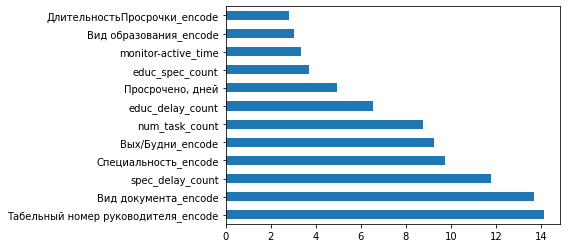

In [40]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(12).plot(kind='barh')

In [41]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['type'] = xgb.predict(df_test)

In [ ]:
submission

In [42]:
submission.to_csv("xgboost_last.csv", index=False)